In [11]:
!pip install pandas matplotlib seaborn scikit-learn beautifulsoup4

In [12]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [21]:
#tyre data scraping from downloaded page of pirelli f1 tyres
def extract_tyre_names_from_html(html_path):
    with open(html_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')

    compound_blocks = soup.find_all('div', id=lambda x: x and x.startswith('accordion-c'))
    tyre_names = []

    for block in compound_blocks:
        title_tag = block.find('div', class_='style_commonText__uKqMs')
        if title_tag:
            name = title_tag.text.strip().split()[0]  # e.g., "C1"
            tyre_names.append(name)

    return pd.DataFrame({'Compound': tyre_names})

In [22]:
html_file_path = "Pirelli Motorsport for Formula 1_ products for circuit racing _ Pirelli.html"
compound_DF = extract_tyre_names_from_html(html_file_path)
print(compound_DF)


  Compound
0       C1
1       C2
2       C3
3       C4
4       C5
5       C6


In [25]:
# pit stop data from ergast api
def get_pitstop_data(season, round_):
    print(f" Fetching pit stop data: {season} Round {round_}")
    url = f"http://ergast.com/api/f1/{season}/{round_}/pitstops.json?limit=100"
    r = requests.get(url)
    data = r.json()
    try:
        return pd.json_normalize(data['MRData']['RaceTable']['Races'][0]['PitStops'])
    except IndexError:
        return pd.DataFrame()

def get_historical_data(start_year=2018, end_year=2024):
    print(f"Collecting historical pit stop data from {start_year} to {end_year}...")
    all_data = []
    for year in range(start_year, end_year + 1):
        for round_ in range(1, 23):
            df = get_pitstop_data(year, round_)
            if not df.empty:
                df['year'] = year
                df['round'] = round_
                all_data.append(df)
    print("✅ Completed pit stop data scraping.")
    return pd.concat(all_data, ignore_index=True)

In [27]:
def parse_duration_to_seconds(duration_str):
    try:
        if ':' in duration_str:
            minutes, seconds = duration_str.split(':')
            return int(minutes) * 60 + float(seconds)
        else:
            return float(duration_str)
    except Exception:
        return None


#preparing training data
df = get_historical_data()
df['stop'] = df['stop'].astype(int)
df['lap'] = df['lap'].astype(int)

print("Converting duration strings to numeric seconds...")
df['duration'] = df['duration'].apply(parse_duration_to_seconds)
df.dropna(subset=['duration'], inplace=True)
print("Duration conversion complete.")

pit_features = df.groupby(['driverId', 'year', 'round']).agg({
    'stop': 'max',
    'lap': ['mean', 'max'],
    'duration': 'mean'
}).reset_index()

pit_features.columns = ['driverId', 'year', 'round', 'num_stops', 'avg_pit_lap', 'last_pit_lap', 'avg_pit_time']

compound_encoding = {'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5, 'C6': 6}
for c in compound_encoding:
    pit_features[c] = 0


 Fetching pit stop data: 2018 Round 1
 Fetching pit stop data: 2018 Round 2
 Fetching pit stop data: 2018 Round 3
 Fetching pit stop data: 2018 Round 4
 Fetching pit stop data: 2018 Round 5
 Fetching pit stop data: 2018 Round 6
 Fetching pit stop data: 2018 Round 7
 Fetching pit stop data: 2018 Round 8
 Fetching pit stop data: 2018 Round 9
 Fetching pit stop data: 2018 Round 10
 Fetching pit stop data: 2018 Round 11
 Fetching pit stop data: 2018 Round 12
 Fetching pit stop data: 2018 Round 13
 Fetching pit stop data: 2018 Round 14
 Fetching pit stop data: 2018 Round 15
 Fetching pit stop data: 2018 Round 16
 Fetching pit stop data: 2018 Round 17
 Fetching pit stop data: 2018 Round 18
 Fetching pit stop data: 2018 Round 19
 Fetching pit stop data: 2018 Round 20
 Fetching pit stop data: 2018 Round 21
 Fetching pit stop data: 2018 Round 22
 Fetching pit stop data: 2019 Round 1
 Fetching pit stop data: 2019 Round 2
 Fetching pit stop data: 2019 Round 3
 Fetching pit stop data: 2019 Round 4

In [53]:
def get_compound_features(circuit_name):
    # Placeholder for actual logic; using C2, C3, C4 as defaults
    return [compound_encoding.get(c, 0) for c in ['C2', 'C3', 'C4'] if c in compound_encoding]

for index, row in pit_features.iterrows():
    circuit_name = 'Monza' 
    compounds = get_compound_features(circuit_name)
    for c in compounds:
        for key, value in compound_encoding.items():
            if value == c:
                pit_features.at[index, key] = 1


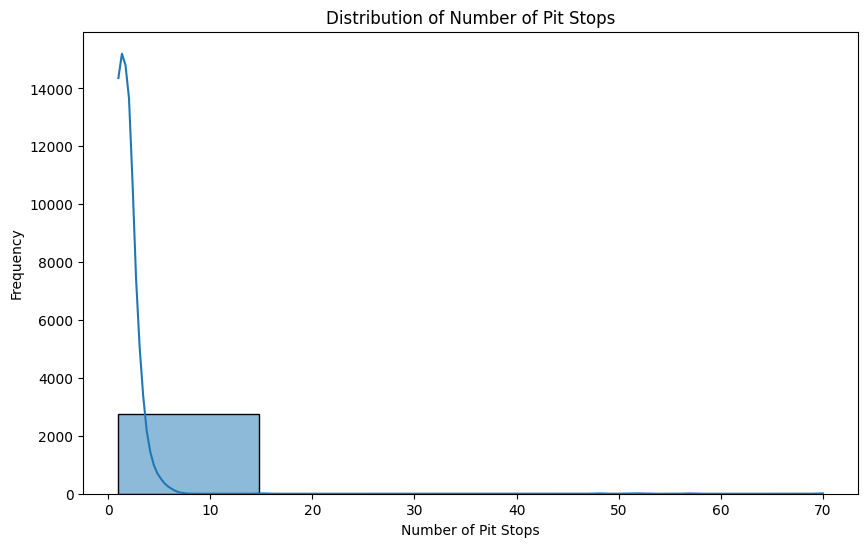

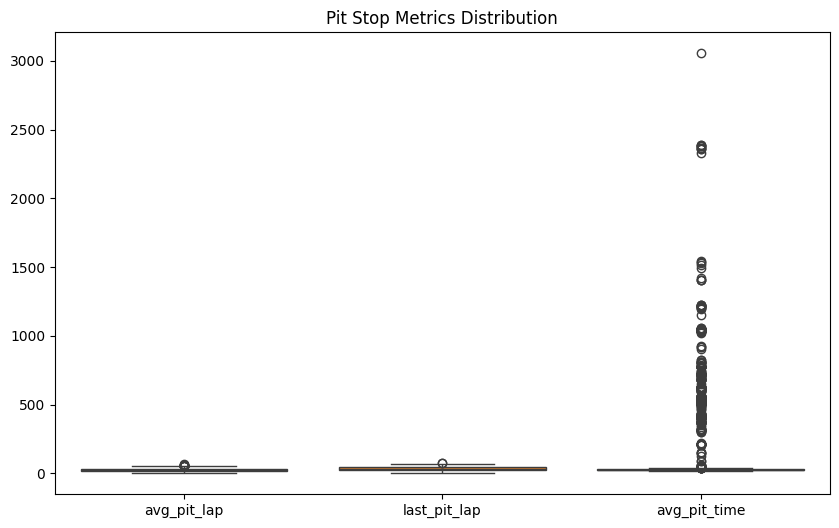

In [54]:
#Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(pit_features['num_stops'], bins=5, kde=True)
plt.title('Distribution of Number of Pit Stops')
plt.xlabel('Number of Pit Stops')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=pit_features[['avg_pit_lap', 'last_pit_lap', 'avg_pit_time']])
plt.title('Pit Stop Metrics Distribution')
plt.show()

In [32]:
#training model for tyre strategy
print("Training tyre strategy prediction model...")
X_tyres = pit_features[['avg_pit_lap', 'last_pit_lap', 'avg_pit_time'] + list(compound_encoding.keys())]
y_tyres = pit_features['num_stops']

model_tyres = RandomForestClassifier()
model_tyres.fit(X_tyres, y_tyres)
print("Tyre strategy model trained.")

Training tyre strategy prediction model...
Tyre strategy model trained.


In [33]:
def get_race_results(season):
    print(f"Fetching race results for {season} season...")
    url = f"http://ergast.com/api/f1/{season}/results.json?limit=1000"
    r = requests.get(url)
    data = r.json()
    races = data['MRData']['RaceTable']['Races']
    rows = []
    for race in races:
        for result in race['Results']:
            rows.append({
                'race_name': race['raceName'],
                'driver': result['Driver']['driverId'],
                'constructor': result['Constructor']['constructorId'],
                'grid': int(result['grid']),
                'position': int(result['position']),
                'fastestLapRank': int(result['FastestLap']['rank']) if 'FastestLap' in result else None
            })
    print("Race results retrieved.")
    return pd.DataFrame(rows)

In [37]:
results_df = get_race_results(2024)
results_df.dropna(inplace=True)

Fetching race results for 2024 season...
Race results retrieved.


Plotting grid vs final position...


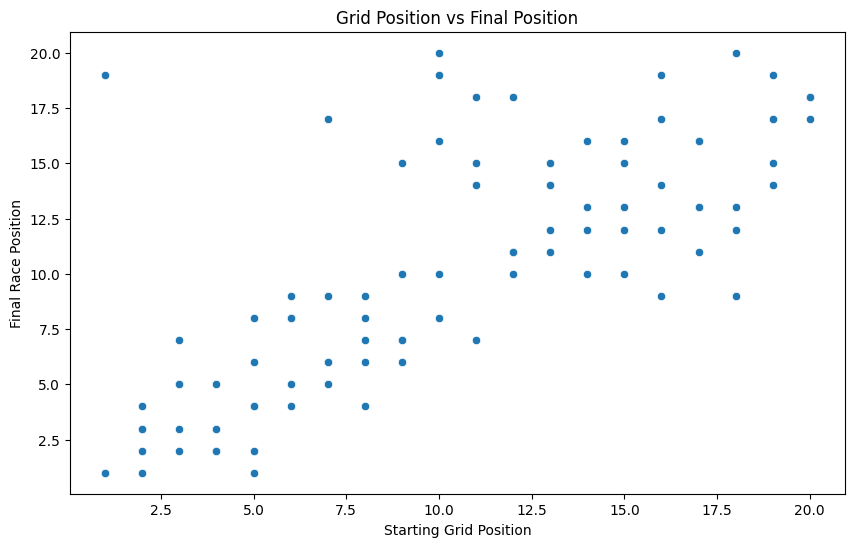

In [39]:
print("Plotting grid vs final position...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='grid', y='position')
plt.title('Grid Position vs Final Position')
plt.xlabel('Starting Grid Position')
plt.ylabel('Final Race Position')
plt.show()

In [40]:
#training for fastest lap & winner models
print("Training fastest lap and winner prediction models...")
X_fastest = results_df[['grid']]
y_fastest = results_df['fastestLapRank'] == 1
model_fastest = RandomForestClassifier()
model_fastest.fit(X_fastest, y_fastest)

X_winner = results_df[['grid']]
y_winner = results_df['position'] == 1
model_winner = RandomForestClassifier()
model_winner.fit(X_winner, y_winner)
print("Models for fastest lap and winner prediction trained.")


Training fastest lap and winner prediction models...
Models for fastest lap and winner prediction trained.


In [51]:
def predict_for_driver(driver_name, avg_pit_lap, last_pit_lap, avg_pit_time, grid_pos, circuit_name):
    print(f"Running prediction for {driver_name} @ {circuit_name}...")

    compounds = get_compound_features(circuit_name)
    compound_features = [0] * 6
    for c in compounds:
        compound_features[c - 1] = 1

    X_input = pd.DataFrame(
        [[avg_pit_lap, last_pit_lap, avg_pit_time] + compound_features],
        columns=['avg_pit_lap', 'last_pit_lap', 'avg_pit_time'] + list(compound_encoding.keys())
    )

    tyre_strategy = model_tyres.predict(X_input)[0]
    is_fastest = model_fastest.predict(pd.DataFrame([[grid_pos]], columns=['grid']))[0]
    is_winner = model_winner.predict(pd.DataFrame([[grid_pos]], columns=['grid']))[0]

    return {
        'Driver': driver_name,
        'Predicted Pit Strategy (stops)': int(tyre_strategy),
        'Tyre Compounds Used': compounds,
        'Fastest Lap Candidate': driver_name if is_fastest else None,
        'Winner Candidate': driver_name if is_winner else None
    }

In [57]:
prediction=predict_for_driver("Lewis Hamilton", 15, 32, 22.5, 5, "Monza")
print("Prediction Output:")
print(prediction)

Running prediction for Lewis Hamilton @ Monza...
Prediction Output:
{'Driver': 'Lewis Hamilton', 'Predicted Pit Strategy (stops)': 2, 'Tyre Compounds Used': [2, 3, 4], 'Fastest Lap Candidate': None, 'Winner Candidate': None}
